#  Indirect dark matter detection detection constatints in the SDFDM

We expect here degenerate masses so we must be carefull about the DM particles that is registered by micrOMEGAS:

We need to edit prtcls1.mld to have the righ order with Nv0 appearing first

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
from hep import *
import pdg_series
from indirectdirect import *
from straightfits import *

## Feynrules implementation
[Preliminary Analysis](../../../../../2016/micromegas_feynrules/correr_micrOMEGAs-markov.ipynb)

See also full results with user galcen in fisica? or gfif?


## Benchmark point

We choose a benchmark point with the following features
* Large $\langle\sigma v\rangle$
* Right relic density

In [3]:
from run_feynrules_SDFM import *

In [4]:
%%bash
cd ../micromegas/SDFDM
make main=main.c > /dev/null

## Parameter scan

In [4]:
a=hep(MODEL='SimplifiedDMSDFDM')

`a-object` is an object with many attributes and methods. Use the tab to explore them. Some of them are
* a.Series: [pandas](http://pandas.pydata.org/) Series object with the "relevant" variables 
* a.LHA: Input LesHouces file as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runSPheno() -> a.LHA_out: return LHA output files as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runmicromegas() -> a.runSPheno() -> Updated the `a-object`  with micrOMEGAS "relevant" output

List of constraints for DM=37 GeV and MD=200 GeV
* $\sigma(\chi_{2,3}^0,\chi^\pm)\operatorname{Br}(\chi^\pm \to \chi_1^0 W^\pm)\operatorname{Br}(\chi_2^0 \to \chi_1^0 Z)<0.3\ \text{pb}$ from fig. 15 of [arXiv:1411.1335](http://arxiv.org/pdf/1411.1335v2)
* 

In [5]:
scan=False # If false load the data from the saved scan files below

In [7]:
if scan:
    pf=pd.DataFrame()
    v=a.vev
    #lambda_1=0.13
    mdf=-200; MN=40; tanb=100.;lam=0.35
    npoints=10000
    for mdf in -np.logspace(np.log10(100),np.log10(1000),npoints):
        ps=pd.Series()
        MN=np.random.uniform(10,50)
        tanb=np.random.uniform(1,100)
        lam=np.random.uniform(0.1,3)
        lu=lam*np.sin(np.arctan(tanb))
        ld=lam*np.cos(np.arctan(tanb))
        devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
        a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
        a.LHA.blocks['MINPAR'][2]='%0.8E       # MDF' %mdf
        a.LHA.blocks['MINPAR'][3]='%0.8E       # MnINPUT' %MN
        a.LHA.blocks['MINPAR'][4]='%0.8E       # lamuINPUT' %lu
        a.LHA.blocks['MINPAR'][5]='%0.8E       # lamdINPUT' %ld
        moc=a.runmicromegas(Direct_Detection=True)
        #print 'Omega h^2, SI proton, neutron, MChi =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI,\
        a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
    #manual pdgs:
        a.pdg['Frep']=-210000601
        mof=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MnINPUT,\
                            lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
    #implement sigma_v
        mo=a.micromegas_output(mof['Full'])
        a.branchings(a.LHA_out.decays,min_pdg=25)
        #print 'Omega h^2, SI proton, sigmav,Br_inv  =',mo.Omega_h2,mo.proton.SI,mo.sigmav,a.Br_names['h0 ->  Chi_1 Chi_1']
        #print a.Br_names['Fre ->  Chi_1 W-'],a.Br_names['Cha.Seriesi_2 ->  Chi_1 Z0']
        a.Series['sigma_chi0_chipm']=0.3 #pb from fig. 15 of arXiv:1411.1335
        a.Series['Chi_1']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
        a.Series['Chi_2']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_2]
        a.Series['Chi_3']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_3]
        a.Series['Fre']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Fre]
        ps=ps.append(a.Series)
        ps=ps.append(a.Br_names)
        ps=ps.append(mo.rename({'Omega_h2':'Omega_h2_mo','proton_SI':'proton_SI_mo','neutron_SI':'neutron_SI_mo'}))
        pf=pf.append(ps,ignore_index=True)
        pf=pf.fillna(0)

In [116]:
if scan: 
    pf.to_csv('scan_full_2.csv',index=False)

In [6]:
if not scan: #load the data from the saved scan files
    pf=pd.read_csv('scan_full.csv')
    pf=pf.append(pd.read_csv('scan_full_2.csv'))
    
pf=pf.sort_values('Chi_1')
pf=pf.reset_index(drop=True)

In [7]:
pf['DD_SI']=0
if pf[pf.proton_SI>pf.neutron_SI].shape[0]==0:
    pf['DD_SI']=pf.neutron_SI
else:
    for i in range(pf.shape[0]):
        pf=pf.reset_index(drop=True)
        pf.loc[i,'DD_SI']=max(pf.proton_SI[i],pf.neutron_SI[i])

In [8]:
Omega_h2_EXP=np.array([0.1197-0.0044,0.1197,0.1197+0.0044])
pf['tanb']=pf.lamuINPUT/pf.lamdINPUT
pf['lambda']=np.sqrt(pf.lamuINPUT**2+pf.lamdINPUT**2)
pf['z_DD_SI']=pf.Omega_h2/Omega_h2_EXP[1]*pf.DD_SI
pf['z2_sigmav']=pf.Omega_h2**2/Omega_h2_EXP[1]**2*pf.sigmav #sigmav calculated from feynrules implemenation

## Constraints
* $\Omega h^2\le(\Omega h^2)_{\text{Planck}}$, at one $\sigma$

In [9]:
pf=pf[pf.Omega_h2<Omega_h2_EXP[2]]
print pf.shape[0],np.abs(pf.Chi_1.min())
opf=pf[ np.logical_and(pf.Omega_h2<Omega_h2_EXP[2],pf.Omega_h2>Omega_h2_EXP[0]) ]

8959 8.99903836


In [10]:
LUX=straightfits()
LUX.read_csv('lux.csv')

In [11]:
AMS=straightfits()
AMS.read_csv('ID_max.csv')

In [12]:
LHC_cs=straightfits()
LHC_cs.read_csv('SDFDM_cs.csv')

In [13]:
LHC_exc_cs=straightfits()
LHC_exc_cs.read_csv('SDFDM_exc_cs.csv')

In [14]:
if LUX.corners.values[0]<np.abs(pf.Chi_1.min()) or LUX.corners.values[-1]>np.abs(pf.Chi_1.max()):
    pf['lux_SI']=LUX(pf['Chi_1'])
else:
    sys.exit('ERROR: Range not covered by function')
    
if AMS.corners.values[0]<np.abs(pf.Chi_1.min()) or AMS.corners.values[-1]>np.abs(pf.Chi_1.max()):
    pf['AMS_ID_bb']=AMS(pf['Chi_1'])
else:
    sys.exit('ERROR: Range not covered by function')

In [15]:
#Temporary cut: DEBUG improve upon function. 
# Includes branchings
pf=pf[np.abs(pf.MDF)>LHC_cs.corners.values[0]]
if LHC_cs.corners.values[0]<np.abs(np.abs(pf.MDF)).min() or LHC_cs.corners.values[-1]>np.abs(np.abs(pf.MDF)).max():
    pf['LHC_cs']=LHC_cs(np.abs(pf.MDF))
else:
    sys.exit('ERROR: Range not covered by function')

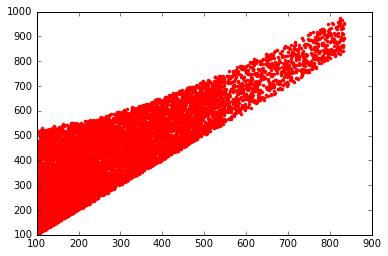

In [16]:
plt.plot(np.abs(pf.MDF),np.abs(pf.Chi_2),'r.')

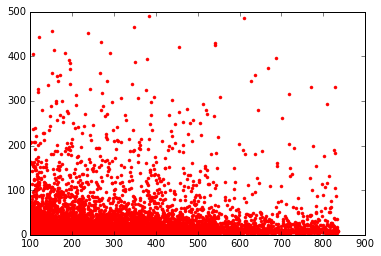

In [259]:
plt.plot(np.abs(pf.MDF),pf.lamdINPUT*a.vev,'r.')

TODO: The constraints in 1411.1335 are in the pure Higgsino limit. The quoted cross section is for either $\chi_2$ or $\chi_3$. 

I must:
* Use prospino to calculate the cross section for point wiht high mixing: $\lambda_{u,d}v\sim MD$
* Filter point not satisfying STU constraints

In [17]:
pf['LHC_cs_br']=pf.LHC_cs*pf['Chi_2 ->  Chi_1 Z0']*pf['Fre ->  Chi_1 W-']

In [18]:
if LHC_exc_cs.corners.values[0]<np.abs(np.abs(pf.MDF)).min() or LHC_exc_cs.corners.values[-1]>np.abs(np.abs(pf.MDF)).max():
    pf['LHC_exc_cs']=LHC_exc_cs(abs(pf.MDF))
else:
    sys.exit('ERROR: Range not covered by function')

* Spin independent direct detection  LUX

In [19]:
lpf=pf[pf.z_DD_SI<pf.lux_SI]
print lpf.shape[0]

8396


* Invisible decay from LHC

In [20]:
hpf=lpf[lpf['h0 ->  Chi_1 Chi_1']<0.19]
hpf.shape

(3203, 148)

* Collider constraints (check large mixing points with prospino)

In [21]:
cpf=hpf[hpf.LHC_cs_br<hpf.LHC_exc_cs]
cpf.shape

(3054, 148)

* STU constraints

* Indirect detection: $\langle\sigma v\rangle$

We will use arXiv:1504.04276 $\chi\overline{\chi}\to b\bar{b}$ constrains with Ein MAX profile frpm AMS-02

In [23]:
spf=lpf[lpf.z2_sigmav<lpf.AMS_ID_bb]
print spf.shape[0]

4623


Points with rescaled relic density less than the Planck value

(7.1992306880000001, 366.50992100000002)

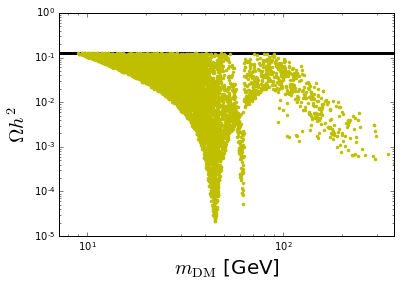

In [24]:
plt.loglog(pf.Chi_1,pf.Omega_h2,'y.')
plt.hlines(Omega_h2_EXP[2],1,1000,lw=3)#np.abs(pf.Chi_1).min(),np.abs(pf.Chi_1).max())
plt.ylabel(r'$\Omega h^2$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.xlim(np.abs(pf.Chi_1).min()*0.8,np.abs(pf.Chi_1).max())

Points with rescaled relic density less than the Planck value in the $\langle\sigma v\rangle$-$m_{\rm DM}$ plane

Blue line: xcluded region from 1504.04276 for $\chi\overline{\chi}\to b\overline{b}$ channel

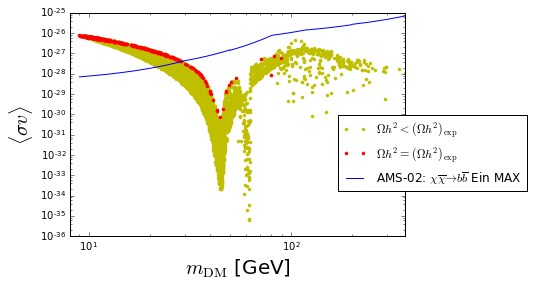

In [25]:
plt.loglog(pf.Chi_1,pf.z2_sigmav,'y.',label=r'$\Omega h^2<(\Omega h^2)_{\rm exp}$')
plt.loglog(opf.Chi_1,opf.z2_sigmav,'r.',label=r'$\Omega h^2=(\Omega h^2)_{\rm exp}$')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,label=r'AMS-02: $\chi\overline{\chi}\to b\overline{b}$ Ein MAX')
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.legend(loc=(0.8,0.2))

rescaled direct detection constraint from LUX

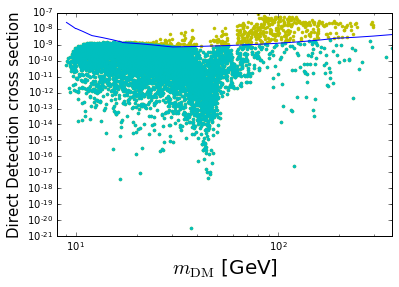

In [26]:
plt.loglog(pf.Chi_1,pf.z_DD_SI,'y.')
plt.loglog(lpf.Chi_1,lpf.z_DD_SI,'c.')
plt.loglog(pf.Chi_1,pf.lux_SI)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'Direct Detection cross section',size=15)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

Points which pass the rescaled direct detection constraint from LUX

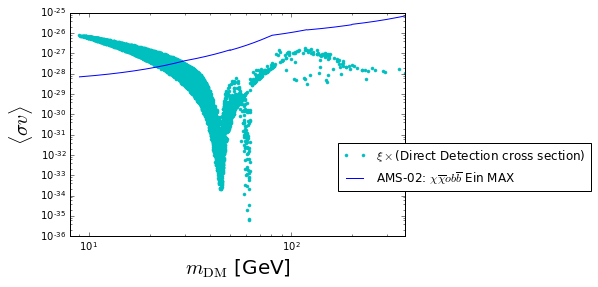

In [27]:
plt.loglog(lpf.Chi_1,lpf.z2_sigmav,'c.',label=r'$\xi\times $(Direct Detection cross section)')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,label='AMS-02: $\chi\overline{\chi}\to b\overline{b}$ Ein MAX')
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.legend(loc=(0.8,0.2))

Points which pass the Higgs invisible decay  constraint from LHC: Br$(h\to \chi\overline{\chi})<0.19$

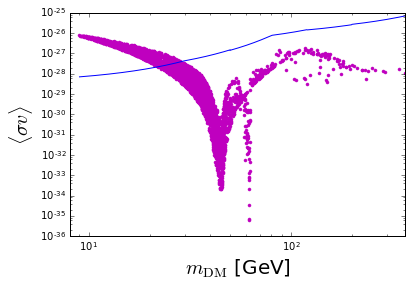

In [28]:
plt.loglog(hpf.Chi_1,hpf.z2_sigmav,'m.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

Points which pass the collider constraints from LHC

In [41]:
expf=hpf[hpf.LHC_cs_br>hpf.LHC_exc_cs]

In [130]:
1+1

2

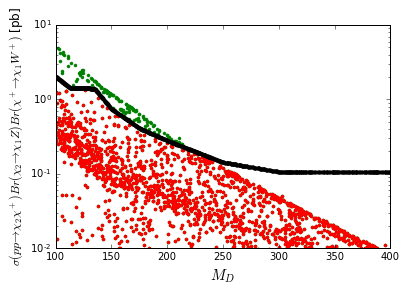

In [139]:
plt.semilogy(np.abs(hpf.MDF),hpf.LHC_cs_br,'g.')
#plt.semilogy(np.abs(expf.MDF),expf.LHC_cs_br,'b.')
plt.semilogy(np.abs(cpf.MDF),cpf.LHC_cs_br,'r.')
plt.semilogy(np.abs(cpf.MDF),cpf.LHC_exc_cs,'k.')
plt.xlim(100,400)
plt.ylim(0.01,10)
plt.xlabel(r'$M_D$',size=15)
plt.ylabel(r'$\sigma(pp\to \chi_2 \chi^+){Br}(\chi_2\to \chi_1 Z){Br}(\chi^+\to \chi_1 W^+)$ [pb]',size=12 )

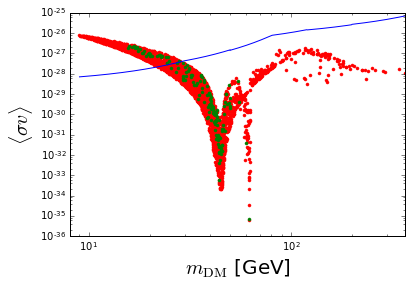

In [46]:
plt.loglog(cpf.Chi_1,cpf.z2_sigmav,'r.')
plt.loglog(expf.Chi_1,expf.z2_sigmav,'g.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

In [74]:
idb=pd.read_csv('ID_best.dat',header=None)
idb=idb.rename(columns={0:'MDF',1:'sigmav'})

In [75]:
idm=pd.read_csv('ID_med.dat',header=None)
idm=idm.rename(columns={0:'MDF',1:'sigmav'})

(1e-29, 1e-25)

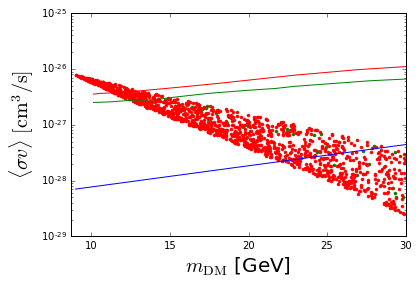

In [76]:
plt.semilogy(expf.Chi_1,expf.z2_sigmav,'g.')
plt.semilogy(cpf.Chi_1,cpf.z2_sigmav,'r.')
plt.semilogy(pf.Chi_1,pf.AMS_ID_bb)
plt.semilogy(idb.MDF,idb.sigmav)
plt.semilogy(idm.MDF,idm.sigmav)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle\ [{\rm cm}^3/{\rm s}]$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.xlim(8.7,30)
plt.ylim(1E-29,1E-25)

## Conclusion
The FULL region excluded by indirect detection (above the blue line in previous) contains points which are not excluded by any other constraint. The upper part of the excluded region between 8 and 30 GeV have the proper relic density

In [78]:
spf=cpf[cpf.z2_sigmav>cpf.AMS_ID_bb]

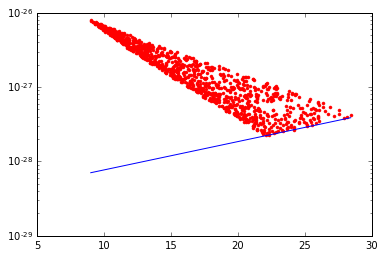

In [81]:
plt.semilogy(spf.Chi_1,spf.z2_sigmav,'r.')
plt.semilogy(spf.Chi_1,spf.AMS_ID_bb)


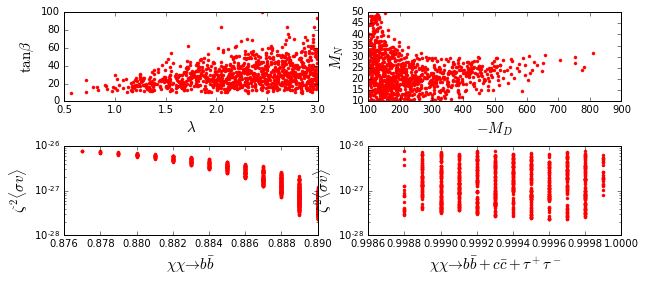

In [129]:
#fig, axes = plt.subplots(nrows=2, ncols=2)
#fig.tight_layout()
fig=plt.figure()
fig.subplots_adjust(hspace=0.5,wspace=0.2,left=0.01,right=1.3)
fig.add_subplot(221)
plt.plot(spf['lambda'],spf.tanb,'r.')
plt.xlabel(r'$\lambda$',size=15)
plt.ylabel(r'$\tan\beta$',size=15)
fig.add_subplot(222)
plt.plot(-spf.MDF,spf.MnINPUT,'r.')
plt.xlabel(r'$-M_D$',size=15)
plt.ylabel(r'$M_N$',size=15)
fig.add_subplot(223)
plt.semilogy(spf['ID_br:~chi,~chi > b b~'],spf.z2_sigmav,'r.')
plt.xlabel(r'$\chi\chi\to b\bar{b}$',size=15)
plt.ylabel(r'$\zeta^2\langle\sigma v\rangle$',size=15)
fig.add_subplot(224)
plt.semilogy(spf['ID_br:~chi,~chi > b b~']+spf['ID_br:~chi,~chi > c c~']+spf['ID_br:~chi,~chi > ta t'],spf.z2_sigmav,'r.')
plt.xlabel(r'$\chi\chi\to b\bar{b}+c \bar{c}+\tau^+\tau^-$',size=15)
plt.ylabel(r'$\zeta^2\langle\sigma v\rangle$',size=15)

Points satisfying all the constrains

In [112]:
for k in spf.keys():
    if k.find('ID_br')>-1:
        print k,spf[k].max()

 ID_br:~chi,~chi > 0.0
ID_br:~chi,~chi > H H 0.0
ID_br:~chi,~chi > W W 0.0
ID_br:~chi,~chi > Z H 0.0
ID_br:~chi,~chi > Z Z 0.0
ID_br:~chi,~chi > a W 0.0
ID_br:~chi,~chi > b b~ 0.89
ID_br:~chi,~chi > c c~ 0.0743
ID_br:~chi,~chi > d d~ 0.0
ID_br:~chi,~chi > mu m 0.000174
ID_br:~chi,~chi > s s~ 0.000478
ID_br:~chi,~chi > t t~ 0.0
ID_br:~chi,~chi > ta t 0.048
ID_br:~chi,~chi > u u~ 0.0
ID_br:~chi,~chi > v v 0.0
ID_br:~chi,~chi > vm vm 0.0
ID_br:~chi,~chi > vt vt 0.0


In [109]:
k='ID_br:~chi,~chi > v v'
k.find('ID_br')

0

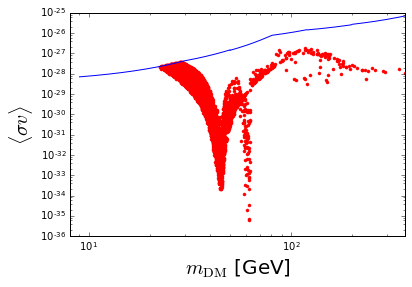

In [152]:
plt.loglog(spf.Chi_1,spf.z2_sigmav,'r.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

(1e-28, 1e-26)

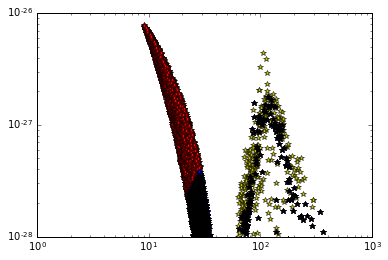

In [87]:

plt.loglog(pf.Chi_1,pf.z2_sigmav,'y*')
plt.loglog(ppf.Chi_1,ppf.z2_sigmav,'r*')
plt.loglog(svf.Chi_1,svf.z2_sigmav,'b*')
plt.loglog(hsv.Chi_1,hsv.z2_sigmav,'k*')
#plt.loglog(hpf[hpf.Fre>400].Chi_1,hpf[np.abs(hpf.Fre)>400].z2_sigmav,'b*')
#plt.plot(ppf.Chi_1) #From 1504.04276 see also 1508.06844
plt.ylim(1E-28,1E-26)

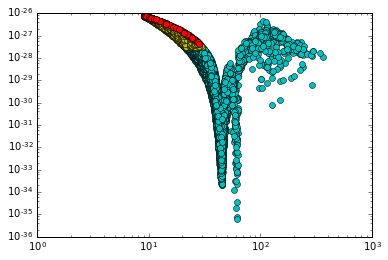

In [22]:
fpf=hpf[np.logical_and(hpf.Chi_1<60,hpf.z2_sigmav>3E-28)]
opf=fpf[np.logical_and(fpf.Omega_h2<Omega_h2_EXP[2],fpf.Omega_h2>Omega_h2_EXP[0])]
plt.loglog(pf.Chi_1,pf.z2_sigmav,'co')
plt.loglog(fpf.Chi_1,fpf.z2_sigmav,'yo')
plt.loglog(opf.Chi_1,opf.z2_sigmav,'ro')

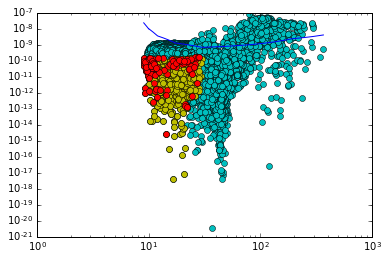

In [23]:
plt.loglog(pf.Chi_1,pf.z_DD_SI,'co')
plt.loglog(fpf.Chi_1,fpf.z_DD_SI,'yo')
plt.loglog(opf.Chi_1,opf.z_DD_SI,'ro')
plt.loglog(pf.sort_values('Chi_1').Chi_1,pf.sort_values('Chi_1').lux_SI,'b-')


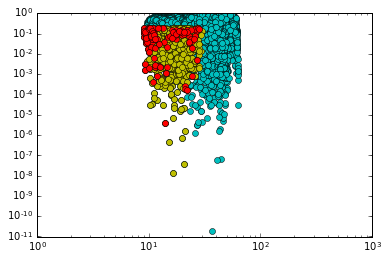

In [24]:
plt.loglog(pf.Chi_1,pf['h0 ->  Chi_1 Chi_1'],'co')
plt.loglog(fpf.Chi_1,fpf['h0 ->  Chi_1 Chi_1'],'yo')
plt.loglog(opf.Chi_1,opf['h0 ->  Chi_1 Chi_1'],'ro')

In [47]:
hpf[['proton_SI','neutron_SI','DD_SI']]

,proton_SI,neutron_SI,DD_SI
0,2.051000e-11,2.103000e-11,2.103000e-11
1,1.274000e-12,1.304000e-12,1.304000e-12
2,5.570000e-11,5.703000e-11,5.703000e-11
3,3.181000e-11,3.260000e-11,3.260000e-11
4,4.730000e-12,4.847000e-12,4.847000e-12
5,5.489000e-11,5.617000e-11,5.617000e-11
6,5.877000e-11,6.018000e-11,6.018000e-11
7,8.528000e-11,8.732000e-11,8.732000e-11
8,2.575000e-13,2.637000e-13,2.637000e-13
9,7.279000e-11,7.460000e-11,7.460000e-11


In [29]:
opf[['Omega_h2','sigmav','Chi_1','Chi_2','Fre','h0 ->  Chi_1 Chi_1','Chi_2 ->  Chi_1 Z0',\
     'Chi_3 ->  Chi_1 Z0','Fre ->  Chi_1 W-','lux_SI','proton_SI','neutron_SI','lambda','tanb',\
    'ID_br:~chi,~chi > b b~']]

,Omega_h2,sigmav,Chi_1,Chi_2,Fre,h0 -> Chi_1 Chi_1,Chi_2 -> Chi_1 Z0,Chi_3 -> Chi_1 Z0,Fre -> Chi_1 W-,lux_SI,proton_SI,neutron_SI,lambda,tanb,"ID_br:~chi,~chi > b b~"
103,0.118,7.320000e-27,9.290680,-442.504616,102.400253,0.003108,0.050054,0.010317,1.000000,1.939738e-08,1.971000e-12,2.017000e-12,2.487868,22.718408,0.878
226,0.117,5.680000e-27,10.998815,-240.915531,105.342170,0.181832,0.188085,0.071620,1.000000,6.345360e-09,1.434000e-10,1.467000e-10,1.283975,25.955958,0.883
235,0.118,5.670000e-27,10.966001,245.829119,105.560722,0.000393,0.084611,0.173617,1.000000,6.454726e-09,2.534000e-13,2.593000e-13,1.276968,18.988941,0.883
299,0.124,7.310000e-27,8.999038,-471.681713,107.127998,0.070210,0.046995,0.009026,1.000000,2.523718e-08,4.756000e-11,4.865000e-11,2.718981,28.302810,0.877
485,0.123,7.190000e-27,9.130613,-446.362231,111.816231,0.118148,0.053979,0.012447,1.000000,2.241171e-08,8.453000e-11,8.647000e-11,2.571289,31.060117,0.877
556,0.116,6.600000e-27,10.088407,-333.191213,113.659453,0.142106,0.095392,0.032050,1.000000,1.019441e-08,1.058000e-10,1.082000e-10,1.853207,29.109257,0.881
566,0.119,6.020000e-27,10.492953,-287.180095,113.921491,0.019874,0.132635,0.059322,1.000000,8.257839e-09,1.301000e-11,1.331000e-11,1.528036,23.566320,0.882
689,0.124,6.800000e-27,9.442659,-385.809282,117.194408,0.034643,0.073682,0.026040,1.000000,1.691145e-08,2.273000e-11,2.325000e-11,2.142112,27.848437,0.879
819,0.123,6.450000e-27,9.849348,-344.335995,120.755853,0.092329,0.096904,0.038451,1.000000,1.171643e-08,6.476000e-11,6.625000e-11,1.892032,29.994150,0.880
972,0.121,5.990000e-27,10.432837,-310.302431,125.086293,0.110250,0.130921,0.059270,1.000000,8.520455e-09,7.943000e-11,8.127000e-11,1.664969,29.950673,0.881


In [171]:
hpf['tanb']=hpf.lamuINPUT/hpf.lamdINPUT
hpf[np.logical_and(hpf.Fre>400,hpf.sigmav>1E-27)][['Chi_1','Chi_2','tanb','Omega_h2']]

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Chi_1,Chi_2,tanb,Omega_h2
605,37.384525,-569.264016,25.976318,0.003740
608,107.860519,520.671280,4.028808,0.038100
612,40.698616,621.749055,19.427396,0.000620
615,24.768280,623.956635,31.557791,0.034700
619,28.239962,-628.046158,30.466414,0.021200
632,70.106061,578.876152,8.633591,0.032500
639,121.795815,486.255817,2.809403,0.043400
651,26.368979,-580.335355,34.176419,0.051100
665,32.524200,-565.152296,33.211961,0.026700
682,49.057502,686.689471,16.579969,0.001490


In [53]:

#mo=run_feynrules_SDFDM(MDF = eval(a.LHA.blocks['MINPAR'][2]),MN = eval(a.LHA.blocks['MINPAR'][3]),\
#                        lu = eval(a.LHA.blocks['MINPAR'][4]),ld = eval(a.LHA.blocks['MINPAR'][5]),v=a.vev)



0.334 2.027e-10 8.08e-29


[4, 6, 13, 15, 1, 3, 5, 23, 24, 25, 1014, 1016, 210000601, 2, 11, 1012]

In [73]:
a.Br_names

Fre ->  Chi_1 W-             1.000000e+00
Chi_3 ->  Frep D UBAR        1.414900e-06
Chi_3 ->  Fre TAU+ NUT       4.404919e-07
Chi_3 ->  Fre SBAR C         1.365783e-06
Chi_3 ->  Frep S CBAR        1.365783e-06
Chi_3 ->  Frep MU- ANUM      4.715199e-07
Chi_3 ->  Fre E+ NUE         4.716334e-07
Chi_3 ->  Fre DBAR U         1.414900e-06
Chi_3 ->  Chi_2 TAU+ TAU-    2.306475e-11
Chi_3 ->  Chi_2 UBAR U       7.506597e-10
Chi_3 ->  Chi_2 SBAR S       9.593106e-10
Chi_3 ->  Chi_2 DBAR D       9.634054e-10
Chi_3 ->  Chi_2 ANUT NUT     4.302990e-10
Chi_3 ->  Chi_1 Z0           5.539797e-01
Chi_3 ->  Fre MU+ NUM        4.715199e-07
Chi_3 ->  Frep TAU- ANUT     4.404919e-07
Chi_3 ->  Chi_2 CBAR C       3.349277e-10
Chi_3 ->  Chi_1 h0           4.460119e-01
Chi_3 ->  Chi_2 ANUM NUM     4.302990e-10
Chi_3 ->  Chi_2 MU+ MU-      2.168401e-10
Chi_3 ->  Frep E- ANUE       4.716334e-07
Chi_3 ->  Chi_2 ANUE NUE     4.302990e-10
Chi_3 ->  Chi_2 E+ E-        2.175491e-10
Chi_2 ->  Chi_1 Z0           8.340

In [12]:
a.Br_names['Fre ->  Chi_1 W-']

0.99984755599999997

## Scan

In [14]:
print mof['Full']


Dark matter candidate is '~chi2' with spin=1/2 mass=1.62E+01

=== MASSES OF HIGGS AND ODD PARTICLES: ===
Higgs masses and widths
      H   125.00 8.79E-03

Masses of odd sector Particles:
~chi : Mchi2 =    16.2 || ~X1n : MDF   =   500.0 || ~chi : Mchi1 =   744.8 
~chi : Mchi3 =   752.6 || ~sk  : Msk   =  3000.0 || 

==== Calculation of relic density =====
Xf=2.24e+01 Omega=1.12e-01
# Channels which contribute to 1/(omega) more than 1%.
# Relative contributions in % are displayed
   23% ~chi2 ~chi2 ->b b~ 
   14% ~chi2 ~chi2 ->s s~ 
   14% ~chi2 ~chi2 ->d d~ 
   11% ~chi2 ~chi2 ->c c~ 
   11% ~chi2 ~chi2 ->u u~ 
    6% ~chi2 ~chi2 ->ve ve~ 
    6% ~chi2 ~chi2 ->vm vm~ 
    6% ~chi2 ~chi2 ->vt vt~ 
    4% ~chi2 ~chi2 ->ta- ta+ 
    3% ~chi2 ~chi2 ->mu- mu+ 
    3% ~chi2 ~chi2 ->e- e+ 
omega_h^2 = 1.12E-01

==== Indirect detection =======
    Channel          vcs[cm^3/s]
 annihilation cross section 2.77E-27 cm^3/s
 contribution of processes
  ~chi2,~chi2 -> b b~   8.88E-01
  ~chi2,~chi2 

In [11]:
if 1==1:
#def pdgf():
    import pandas as pd
    import pdg as pdgtmp
    #pdg=pd.Series()
    pdg_id=pdgtmp.pdgid_names
    pdg_name=pd.Series( dict((v,k) for k,v in pdgtmp.pdgid_names.iteritems()) )
    def pdg_add(id)

In [15]:
#Design:
pdg_name.A0 -> 34
pdg_id[36] -> 'A0'
pdg_add(8)='T' -> update:  pdg.name.T ; pdg.id[36]

36

In [2]:
self.pdg
























































class hep(model):
class hep(model):


















































































pdg.pdgid_names[210000601]='Fre'

NameError: name 'pdg' is not defined

In [31]:
pdg.

{-9900042: 'Higgs_minus_minus_R',
 -9900041: 'Higgs_minus_minus_L',
 -2000015: 's_tau_plus_2',
 -2000013: 's_mu_plus_R',
 -2000011: 's_e_plus_R',
 -2000006: 's_tbar_2',
 -2000005: 's_bbar_2',
 -2000004: 's_cbar_R',
 -2000003: 's_sbar_R',
 -2000002: 's_ubar_R',
 -2000001: 's_dbar_R',
 -1000037: 's_chi_minus_2',
 -1000024: 's_chi_minus_1',
 -1000016: 's_anti_nu_tau_L',
 -1000015: 's_tau_plus_1',
 -1000014: 's_anti_nu_mu_L',
 -1000013: 's_mu_plus_L',
 -1000012: 's_anti_nu_e_L',
 -1000011: 's_e_plus_L',
 -1000006: 's_tbar_1',
 -1000005: 's_bbar_1',
 -1000004: 's_cbar_L',
 -1000003: 's_sbar_L',
 -1000002: 's_ubar_L',
 -1000001: 's_dbar_L',
 -40213: 'rho_3S_minus',
 -30213: 'rho_2S_minus',
 -20543: 'B_prime_c1_minus',
 -20533: 'anti_B_prime_s10',
 -20523: 'B_prime_1_minus',
 -20513: 'anti_B_prime_10',
 -20433: 'D_prime_s1_minus',
 -20423: 'anti_D_prime_10',
 -20413: 'D_prime_1_minus',
 -20323: 'K_prime_1_minus',
 -20313: 'anti_K_prime_10',
 -20213: 'a_1_minus',
 -20211: 'pi_2S_minus',
 -1054

In [15]:
a.LHA_out.blocks['MASS']

MASS { 25 :  126; 23 :  91.2; 24 :  80.3; 1 :  0.005; 3 :  0.095; 5 :  4.18; 2 :  0.0025; 4 :  1.27; 6 :  174; 11 :  0.000511; 13 :  0.106; 15 :  1.78; 210000601 :  500; 1012 :  16.2; 1014 : -745; 1016 :  753 }

In [16]:
cat SPheno.spc.SimplifiedDMSDFDM

# SUSY Les Houches Accord 2 - SimplifiedDM/SDFDM Spectrum + Decays + Flavor Observables
# SPheno module generated by SARAH
# ----------------------------------------------------------------------
# SPheno v3.3.8  
#   W. Porod, Comput. Phys. Commun. 153 (2003) 275-315, hep-ph/0301101
#   W. Porod, F.Staub, Comput.Phys.Commun.183 (2012) 2458-2469, arXiv:1104.1573
# SARAH: 4.8.5   
#   F. Staub; arXiv:0806.0538 (online manual)
#   F. Staub; Comput. Phys. Commun. 181 (2010) 1077-1086; arXiv:0909.2863
#   F. Staub; Comput. Phys. Commun. 182 (2011)  808-833; arXiv:1002.0840
#   F. Staub; Comput. Phys. Commun. 184 (2013)  1792-1809; arXiv:1207.0906
#   F. Staub; Comput. Phys. Commun. 185 (2014)  1773-1790; arXiv:1309.7223 
# Including the calculation of flavor observables based on the FlavorKit 
#   W. Porod, F. Staub, A. Vicente; Eur.Phys.J. C74 (2014) 8, 2992; arXiv:1405.1434 
# Two-loop masss corrections to Higgs fields based on 
#   M. D. Goodsell, K. Nickel, F. Staub; arXiv:1411.0675 
#

In [64]:
print re.search('^[0-9\.eE\-\+]*$','a')

None


In [159]:
idc='0'
br=re.search('[0-9]\.[0-9eE\-\+]+',idc)
if br:
    br=br.group(0)
    if re.search(fltchk,br):
        print br

In [156]:
kk

In [127]:
micromegas

ID                     2.770000e-27
ID:~chi,~chi > b b~    8.880000e-01
ID:~chi,~chi > c c~    6.750000e-02
ID:~chi,~chi > ta t    4.390000e-02
ID:~chi,~chi > s s~    4.380000e-04
ID:~chi,~chi > mu m    1.580000e-04
dtype: float64

In [136]:
df=pd.DataFrame()
df=df.append(micromegas,ignore_index=True)

In [138]:
df.append({'ID':3,'ID:aa':4},ignore_index=True).fillna(0)

,ID,"ID:~chi,~chi > b b~","ID:~chi,~chi > c c~","ID:~chi,~chi > mu m","ID:~chi,~chi > s s~","ID:~chi,~chi > ta t",ID:aa
0,2.770000e-27,0.888,0.0675,0.000158,0.000438,0.0439,0
1,3.000000e+00,0.000,0.0000,0.000000,0.000000,0.0000,4


In [134]:
df

,ID,"ID:~chi,~chi > b b~","ID:~chi,~chi > c c~","ID:~chi,~chi > mu m","ID:~chi,~chi > s s~","ID:~chi,~chi > ta t"
0,2.770000e-27,0.888,0.0675,0.000158,0.000438,0.0439


In [94]:
cc=re.finditer('[0-9\.eE\-\+]+',c)
[g.group(0) for g in cc]

In [104]:
c

'  ~chi2,~chi2 -> mu- m  1.58E-04'

In [115]:
re.sub('\s+$','',re.sub('^\s+','',re.sub('[0-9\.eE\-\+]+','',c)))

'~chi,~chi > mu m'

'1.58E-04'

## Scan $m_{DM}$
### Higgsilino-like

In [9]:
df=pd.DataFrame()
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
dm_masses=np.linspace(100,1200,100)
for MDM in dm_masses:
    if np.where(dm_masses==MDM)[0][0]%10==0: #find the index of the array entry
        print np.where(dm_masses==MDM)[0][0]
    a.LHA.blocks['MINPAR'][2]='%0.8E       #MDF' %MDM  # -> Fill a.Series.MDF
    a.runmicromegas(Direct_Detection=True)
    mo=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MnINPUT,\
                        lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
    mo=a.micromegas_output(mo['Full'])
    a.Series['Omega_h2_official']=mo.Omega_h2
    a.Series['proton_SI_official']=mo.proton.SI
    a.Series['neutron_SI_official']=mo.neutron.SI
    df=df.append(a.Series,ignore_index=True)

0
10
20
30
40
50
60
70
80
90


### Relic density

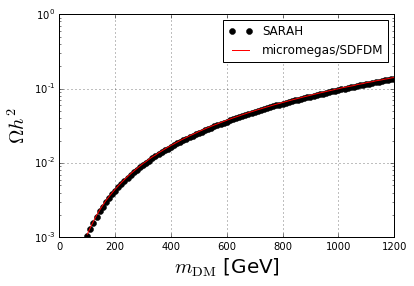

In [10]:
plt.semilogy(df.MDF,df.Omega_h2,'ko',label='SARAH')
plt.semilogy(df.MDF,df.Omega_h2_official,'r-',label='micromegas/SDFDM')
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.ylabel(r'$\Omega h^2$',size=20)
plt.grid()
plt.legend(loc='best')
plt.savefig('omega.pdf')


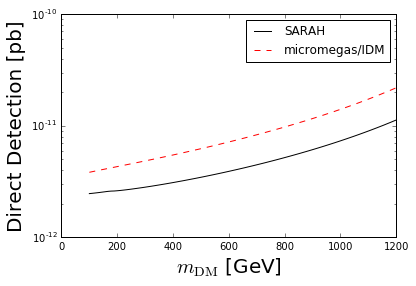

In [11]:
plt.semilogy(df.MDF,df.proton_SI,'k-',label='SARAH')
plt.semilogy(df.MDF,df.proton_SI_official,'r--',label='micromegas/IDM')
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.ylabel(r'Direct Detection [pb]' ,size=20)
plt.legend(loc='best')
plt.savefig('dd.pdf')

### Singlet-like

In [12]:
dn=pd.DataFrame()
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][2]='%0.8E       #MDF' %1200  # -> Fill a.Series.MDF


dm_masses=np.linspace(100,1200,100)
for MDM in dm_masses:
    if np.where(dm_masses==MDM)[0][0]%10==0: #find the index of the array entry
        print np.where(dm_masses==MDM)[0][0]
    a.LHA.blocks['MINPAR'][3]='%0.8E       #MN' %MDM  # -> Fill a.Series.MN
    a.runmicromegas(Direct_Detection=True)
    mo=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MN,\
                        lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
    mo=a.micromegas_output(mo['Full'])
    a.Series['Omega_h2_official']=mo.Omega_h2
    a.Series['proton_SI_official']=mo.proton.SI
    a.Series['neutron_SI_official']=mo.neutron.SI
    dn=dn.append(a.Series,ignore_index=True)

0
10
20
30
40
50
60
70
80
90


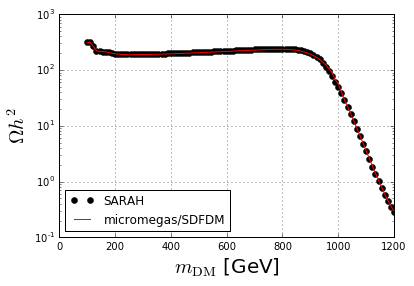

In [13]:
plt.semilogy(dn.MN,dn.Omega_h2,'ko',label='SARAH')
plt.semilogy(dn.MN,dn.Omega_h2_official,'r-',label='micromegas/SDFDM')
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.ylabel(r'$\Omega h^2$',size=20)
plt.grid()
plt.legend(loc='best')
plt.savefig('omega.pdf')

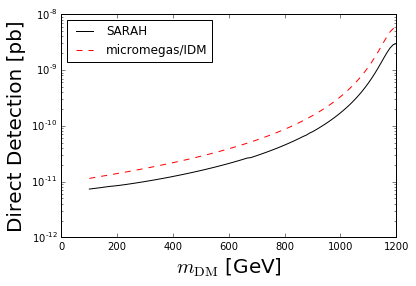

In [14]:
plt.semilogy(dn.MN,dn.proton_SI,'k-',label='SARAH')
plt.semilogy(dn.MN,dn.proton_SI_official,'r--',label='micromegas/IDM')
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.ylabel(r'Direct Detection [pb]' ,size=20)
plt.legend(loc='best')
plt.savefig('dd.pdf')

## Pure higssino limit

In [15]:
v=a.vev
#lambda_1=0.13
mdf=100
mn=2000
lambdau=1E-4
lambdad=1E-4
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][2]='%0.8E       #MDF' %mdf
a.LHA.blocks['MINPAR'][3]='%0.8E       #MN' %mn
a.LHA.blocks['MINPAR'][4]='%0.8E       # lamuINPUT' %lambdau
a.LHA.blocks['MINPAR'][5]='%0.8E       # lamdINPUT' %lambdad
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega h^2, SI proton, neutron =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI

Omega h^2, SI proton, neutron = 0.00103 2.47e-24 2.536e-24


In [16]:
a.LHA.blocks['MINPAR'].entries

_dict([(1, '1.3000000E-01  # lambda1INPUT'),
       (2, '1.00000000E+02       #MDF'),
       (3, '2.00000000E+03       #MN'),
       (4, '1.00000000E-04       # lamuINPUT'),
       (5, '1.00000000E-04       # lamdINPUT')])

In [17]:
mo=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MN,\
                        lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
#implement sigma_v
mo=a.micromegas_output(mo['Full'])
print mo.Omega_h2,mo.proton.SI

0.00107 3.835e-24


In [ ]:
1+1

[Jupyter home](./draft.pdf)